# weighting sample by minimize KL via Information Estimator

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from scipy.spatial import distance

In [4]:
np.random.seed(123)
x = np.random.multivariate_normal(mean = [0,0], cov = [[1,0],[0,1]], size = 100)
y = np.random.multivariate_normal(mean = [1.5,1.5], cov = [[1,0],[0,1]], size = 100)

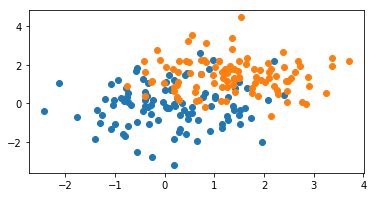

In [11]:
plt.figure(figsize=(6,3))
plt.plot(x[:,0],x[:,1], 'o' )
plt.plot(y[:,0],y[:,1], 'o' )

In [16]:
x.shape

(100, 2)

## make objective vector
データ点$i = 1$に注目した時の目的関数
$\sum_{i=1,i\neq1}\left( \frac{w_i}{(1-w_1)^2}+\frac{w_i}{1-w_i}\log||x_1-x_j|| \right) - \sum_{j=1}\log||x_1 -y_j||$

### internal log component
$\sum_{i=1,i\neq1}\log||x_1-x_j|| $

距離行列を計算する & $\Sigma\log$(各データ点間の距離)をとるので、対角成分は0にする

In [90]:
data_num = x.shape[0]
# make dist matrix
dist_mat_x =distance.cdist(x, x)
# set diagnal component as 0
dist_mat_x[([i for i in range(data_num)], [i for i in range(data_num)])] = 1
log_mat_x = np.log(dist_mat_x)

### weight component
$\sum_{i=1,i\neq1}\frac{w_i}{(1-w_1)^2}+\frac{w_i}{1-w_i}$

この部分を毎回更新する

In [91]:
# initialize weight vector
weight = np.random.uniform(size = data_num)
weight/= np.sum(weight)

In [152]:
# left component
## numeraters matrix
le_numeras_tile = np.tile(weight, (data_num, 1))
# denominators matrix
le_denoms = (1 - weight)**2
le_denoms_tile = np.tile(le_denoms, (data_num, 1)).T
# left_component matrix
mat_le = (le_numeras_tile / le_denoms_tile)

# right component
ri = 1/((1 / weight) - 1)
mat_ri = np.tile(ri, (data_num,1)).T

mat_first = mat_le + mat_ri

In [171]:
mat_first

array([[0.03267257, 0.03504538, 0.02036433, ..., 0.02916203, 0.02540232,
        0.02235234],
       [0.03512811, 0.03751203, 0.02276218, ..., 0.03160111, 0.02782378,
        0.02475951],
       [0.02011984, 0.0224362 , 0.00810442, ..., 0.01669282, 0.01302255,
        0.01004514],
       ...,
       [0.02906093, 0.03141742, 0.01683728, ..., 0.02557451, 0.02184064,
        0.01881163],
       [0.02522084, 0.02756005, 0.01308683, ..., 0.02175999, 0.0180535 ,
        0.01504671],
       [0.02212665, 0.02445198, 0.01006464, ..., 0.01868634, 0.01500184,
        0.01201288]])

重み成分とデータ点間の距離の積

→行列演算の形で

In [157]:
entropy = np.diag(np.dot(mat_first, log_mat_x))

### outer log component
$\sum_{j=1}\log||x_1-y_j|| $

In [172]:
# constant value !
#calculate  only once
dist_mat_xy = distance.cdist(x, y)
log_mat_xy = np.log(dist_mat_xy)
CE = np.sum(log_mat_xy, axis = 1) / data_num

In [173]:
grad = entropy - CE

In [218]:
def cal_MKLW(train, test, rep = 10000, lr = 1e-5):
    """Calculate optimal weights of training data to minimize KL between train and test

    # Arguments:
        train(np.ndarray): train data assigned to weights(n_data, n_dim)
        test(np.ndarray): test data we do not use for training
        rep(int): maximum repeat number of maximum gradient method
        lr(int): leraning rate of gradient method
    """
    
    data_num = train.shape[0]
    
    # CE component
        # This is constant value !
        #calculate  only once!
    dist_mat_xy = distance.cdist(x, y)
    log_mat_xy = np.log(dist_mat_xy)
    CE = np.sum(log_mat_xy, axis = 1) / data_num

    # Self-entropy component
        # internal log component
    # make dist matrix of train
    dist_mat_train =distance.cdist(train, train)
    # set diagnal component as 0
    dist_mat_train[([i for i in range(data_num)], [i for i in range(data_num)])] = 1
    log_mat_train = np.log(dist_mat_train)
    
    
        # weight component
    # initialize weight vector
    weight = np.random.uniform(size = data_num)
    weight/= np.sum(weight)
    
    for i in range(rep):
            # left component
    ## numeraters matrix
        le_numeras_tile = np.tile(weight, (data_num, 1))
            # denominators matrix
        le_denoms = (1 - weight)**2
        le_denoms_tile = np.tile(le_denoms, (data_num, 1)).T
            # left_component matrix
        mat_le = (le_numeras_tile / le_denoms_tile)

            # right component
        ri = 1/((1 / weight) - 1)
        mat_ri = np.tile(ri, (data_num,1)).T
        # sum of left and right
        mat_first = mat_le + mat_ri
        #self-entropy
        entropy = np.diag(np.dot(mat_first, log_mat_x))
        weight -= lr * (entropy - CE)
        weight /=weight.sum()
    return(weight)

In [222]:
res = cal_MKLW(x,y, rep = 1000000)

In [223]:
res

array([ 5.08174756e-03,  1.20636173e-02, -9.14719792e-04,  5.38224293e-03,
        6.13122191e-03,  2.46969431e-02,  3.13995274e-03,  2.70698640e-02,
       -7.05412735e-03, -1.92390631e-03, -8.49725423e-03,  3.46931721e-03,
        1.32584053e-02,  8.28796341e-03,  2.13456392e-02,  5.35051077e-03,
        8.65221511e-03,  6.40534505e-03,  6.12352046e-03,  1.75359794e-02,
        1.02960284e-02,  1.24252605e-02,  2.05595139e-02, -5.49869533e-03,
       -8.01146321e-03,  1.16271125e-02,  1.84460869e-03, -1.02345900e-03,
       -8.85255979e-03, -9.30649005e-03,  7.80539864e-03,  1.34512836e-02,
       -8.10230676e-03,  3.76664744e-02,  1.29181729e-02,  1.76656292e-02,
        7.22188254e-03,  3.27008777e-03,  3.19253124e-02,  1.11264280e-02,
        5.74573171e-03, -8.18487931e-03,  1.77960381e-02,  1.47489337e-02,
       -4.36729081e-03,  6.99539766e-03, -3.27818384e-03,  2.53807037e-03,
        1.15513407e-02,  2.40027668e-02,  7.09336784e-03, -6.17103015e-03,
        2.89181914e-02,  

/home/lab/nakakei/.pyenv/versions/3.6.5/envs/env_mac/lib/python3.6/site-packages/matplotlib/collections.py:853: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


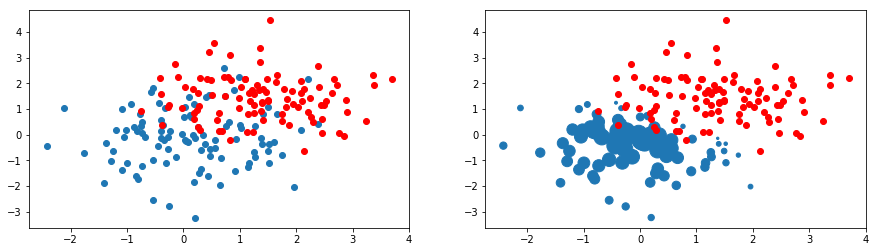

In [229]:
plt.figure(figsize = (15,4))
plt.subplot(1,2,1)
plt.scatter(x[:,0], x[:,1])
plt.plot(y[:,0], y[:,1], 'ro')
plt.subplot(1,2,2)
plt.scatter(x[:,0], x[:,1], s = res*10000)
plt.plot(y[:,0], y[:,1], 'ro')